In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import sys
from functools import partial
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr

In [2]:
%%capture
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from descriptive_stats import get_descriptive_table

# 1) Prepare data

## 1.1) Merge data

In [3]:
df1 = pd.read_excel('../Data/SK1_pgeld.xlsx', index_col='sk1_id')
df2 = pd.read_excel('../Data/SK2_pgeld.xlsx', index_col='sk1_id')

# save id, unique ids per study
df1['sk1_id'] = df1.index
df2['sk1_id'] = df2.index
df1['id'] = 'sk1_' + df1.index.astype(str)
df2['id'] = 'sk2_' + df2.index.astype(str)
df1.set_index('id', inplace=True)
df2.set_index('id', inplace=True)

In [4]:
# additional LR data
df1_add = pd.read_excel('../Data/SK1_pgeld_oct2022.xlsx', index_col='sk1_id')
df2_add = pd.read_excel('../Data/SK2_pgeld_oct2022.xlsx', index_col='sk1_id')

# save id, unique ids per study
df1_add['id'] = 'sk1_' + df1_add.index.astype(str)
df2_add['id'] = 'sk2_' + df2_add.index.astype(str)
df1_add.set_index('id', inplace=True)
df2_add.set_index('id', inplace=True)

df1 = df1.join(df1_add)
df2 = df2.join(df2_add)

In [5]:
# map variables
mapping_df = pd.read_csv('../Data/vars_mapping.csv', index_col='Name')
col = 'Corresponding follow-up var'
mapping_df = mapping_df[(mapping_df[col] != 'MISSING') * (~mapping_df[col].isna())]

for index, row in mapping_df.iterrows():
    df2.rename(columns={row[col]: index}, inplace=True)

# changed encoding
df2['urine_incomplete'] = df2['urine_incomplete'].apply(lambda x: "Complete" if x == 1 else ("Incomplete" if x == 2 else np.nan))
    
# merge
df1['source'] = 'sk1'
df2['source'] = 'sk2'
df_orig = pd.concat([df1, df2], ignore_index=True)

/tmp/ipykernel_306420/3174880260.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['source'] = 'sk1'
/tmp/ipykernel_306420/3174880260.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['source'] = 'sk2'


In [6]:
# sanity checks
assert(len(df_orig) - len(df1) - len(df2) == 0)

df = df_orig.copy(deep=True)

In [7]:
def count_participants(df):
    return np.array([
        len(df),  # total
        (df['source'] == 'sk1').sum(),  # sk1
        (df['source'] == 'sk2').sum(),  # sk2
        len(set(df[df['source'] == 'sk1']['sk1_id']) & set(df[df['source'] == 'sk2']['sk1_id'])),  # common
    ])

N0 = count_participants(df_orig)
N = N0
print('Sample size: {} ({} + {}, common {}).'.format(*N0))
print(f"Included in SK1 but not SK2: {len(set(df1['sk1_id']) - set(df2['sk1_id']))}.")
print(f"Included in SK2 but not SK1: {len(set(df2['sk1_id']) - set(df1['sk1_id']))}.")

Sample size: 2163 (1129 + 1034, common 984).
Included in SK1 but not SK2: 145.
Included in SK2 but not SK1: 50.


## 1.2) Filter data

### 1.2.1) Data available

In [8]:
# sodium collection
df = df[~df['una_u24_mmol'].isna()]
print(f"Night urinary sodium missing = {N - count_participants(df)}.")
N = count_participants(df)

Night urinary sodium missing = [133  27 106 116].


In [9]:
# urine volume
df = df[~df['u24_ml'].isna()]
print(f"Urine missing volume = {N - count_participants(df)}")
N = count_participants(df)

Urine missing volume = [0 0 0 0]


In [10]:
# creatinine
df = df[~df['ucrt_u24_umol'].isna()]
print(f"Creatinine missing = {N - count_participants(df)}")
N = count_participants(df)

Creatinine missing = [2 1 1 2]


In [11]:
# collection times
df = df[~df.un_min.isna()]
df = df[~df.u24_min.isna()]
df = df[df.un_min > 0.]
print(f"Collection durations unavailable = {N - count_participants(df)}")
N = count_participants(df)
print('Sample size: {} ({} + {}, common {}).'.format(*N))

Collection durations unavailable = [3 3 0 3]
Sample size: 2025 (1098 + 927, common 863).


### 1.2.2) Completeness criteria

In [12]:
# self-reported completeness
df = df[df['urine_incomplete'] == 'Complete']
print(f"Self-reported incompleteness of collection = {N - count_participants(df)}")
N = count_participants(df)

Self-reported incompleteness of collection = [16 15  1 10]


In [13]:
# creatinine criteria
df = df[~(
    ((df['u24_ml'] < 1e3) * (df['ucrt_u24_umol'] < (6.0 * 1e3)))
    + (df['ucrt_u24_umol'] < (5.0 * 1e3)))]
print(f"Creatinine criteria not fulfilled = {N - count_participants(df)}")
N = count_participants(df)

Creatinine criteria not fulfilled = [22  6 16 16]


In [14]:
print('Sample size: {} ({} + {}, common {}).'.format(*N))

Sample size: 1987 (1077 + 910, common 837).


### 1.2.3) Night duration criteria

In [15]:
df['un_hours'] = df['un_min'] / 60
df['ud_hours'] = df['ud_min'] / 60
df['u24_hours'] = df['u24_min'] / 60

In [16]:
df_no_min_duration = df.copy()

In [17]:
df = df[~((df['un_hours'] < 5) + (df['un_hours'] > 11))]
print(f"Night duration not in [5, 11] = {N - count_participants(df)} ({(100 * (N - count_participants(df)) / N).round(2)} % of the otherwise eligible participants).")
N = count_participants(df)

Night duration not in [5, 11] = [123  51  72  86] ([ 6.19  4.74  7.91 10.27] % of the otherwise eligible participants).


In [18]:
df['ud_hours'].min()

5.833333333333333

### 1.2.4) Whole-day collection duration criteria

In [19]:
df = df[~((df['u24_hours'] < 21) + (df['u24_hours'] > 27))]
print(f"Whole-day duration not in [21, 27] = {N - count_participants(df)} ({(100 * (N - count_participants(df)) / N).round(2)} % of the otherwise eligible participants).")
N = count_participants(df)

Whole-day duration not in [21, 27] = [107  64  43  84] ([ 5.74  6.24  5.13 11.19] % of the otherwise eligible participants).


In [20]:
print('Sample size: {} ({} + {}, common {}).'.format(*N))

Sample size: 1757 (962 + 795, common 667).


## 1.3) Correct data

Corrections decided after looking at the data when developing models.

In [21]:
# non-smokers should have 0 cigarettes in current smoking, not missing
print(df[df['t_ctf'].isna()]['t_now'].value_counts(dropna=False))
print(df[df['t_ct'].isna()]['t_now'].value_counts(dropna=False))
df.loc[(df['t_now'] == 'No') * (df['t_ct'].isna()), 't_ct'] = 0.
df.loc[(df['t_now'] == 'No') * (df['t_ctf'].isna()), 't_ctf'] = 0.
# if missing in one category but not other, then probably 0
df.loc[(df['t_ct'].isna()) * (~df['t_ctf'].isna()), 't_ct'] = 0.
df.loc[(df['t_ctf'].isna()) * (~df['t_ct'].isna()), 't_ctf'] = 0.

No     1154
Yes      14
NaN      10
Name: t_now, dtype: int64
No     1154
Yes      84
NaN      10
Name: t_now, dtype: int64


In [22]:
def unify_labels(mapper):
    return lambda x: mapper[x] if x in mapper else x

df['e_p_past'] = df['e_p_past'].apply(unify_labels({2.0: 'No', 1.0: 'Yes', -9.0: np.nan}))
df['p_act4'] = df['p_act4'].apply(unify_labels({2.0: 'No', 1.0: 'Yes', -9.0: np.nan}))
df['sc_now'] = df['sc_now'].apply(unify_labels({2.0: 'No', 1.0: 'Yes', -9.0: np.nan}))
df['origin_final'] = df['origin_final'].apply(unify_labels({-9.0: np.nan}))
df['orig_regio'] = df['orig_regio'].apply(unify_labels({'Ne sait pas': np.nan}))
df['p_h_income'] = df['p_h_income'].apply(unify_labels({'Not willing to answer': np.nan, 'Does not know': np.nan}))

# 2) Normalization

In [23]:
# correction to 24h values
df['una_u24corr_mmol'] = 24 * df['una_u24_mmol'] / df['u24_hours']
df['uk_u24corr_mmol'] = 24 * df['uk_u24_mmol'] / df['u24_hours']
df['ucrt_u24corr_umol'] = 24 * df['ucrt_u24_umol'] / df['u24_hours']
df['u24corr_ml'] = 24 * df['u24_ml'] / df['u24_hours']
df['u24corr_min'] = 24 * 60 * df['u24_min'] / df['u24_min']
print(df['u24corr_min'].min(), df['u24corr_min'].max())

1440.0 1440.0


In [24]:
# by duration
# uncorrected to 24 hours
df['una_un_mmol_norm_min'] = df.una_un_mmol * df.u24_min / df.un_min
df['una_ud_mmol_norm_min'] = df.una_ud_mmol * df.u24_min / df.ud_min
# corrected to 24 hours
df['una_un_mmol_norm_min_corr'] = df.una_un_mmol * (24 * 60) / df.un_min
df['una_ud_mmol_norm_min_corr'] = df.una_ud_mmol * (24 * 60) / df.ud_min

# by average volume
# uncorrected to 24 hours
avg_v_n = df.un_ml.mean()
avg_v_d = df.ud_ml.mean()
avg_v_24 = df.u24_ml.mean()
night_norm = avg_v_24 / avg_v_n
day_norm = avg_v_24 / avg_v_d
df['una_un_mmol_norm_vol'] = df.una_un_mmol * night_norm
df['una_ud_mmol_norm_vol'] = df.una_ud_mmol * day_norm
print(f'Overnight volume-based normalization constant: {night_norm}.')
print(f'Daily volume-based normalization constant: {day_norm}.')
print(f'Percentage of volume excreted overnight: {100 / night_norm}.')
print(f'Percentage of volume excreted during the day: {100 / day_norm}.')
# corrected to 24 hours
avg_v_24_corr = df.u24corr_ml.mean()
night_norm_corr = avg_v_24_corr / avg_v_n
day_norm_corr = avg_v_24_corr / avg_v_d
df['una_un_mmol_norm_vol_corr'] = df.una_un_mmol * night_norm_corr
df['una_ud_mmol_norm_vol_corr'] = df.una_ud_mmol * day_norm_corr
print(f'Overnight volume-based normalization constant: {night_norm_corr}.')
print(f'Daily volume-based normalization constant: {day_norm_corr}.')
print(f'Percentage of volume excreted overnight: {100 / night_norm_corr}.')
print(f'Percentage of volume excreted during the day: {100 / day_norm_corr}.')


Overnight volume-based normalization constant: 3.196296452242221.
Daily volume-based normalization constant: 1.4553119406895596.
Percentage of volume excreted overnight: 31.286209365795656.
Percentage of volume excreted during the day: 68.71379063420434.
Overnight volume-based normalization constant: 3.2139595082176067.
Daily volume-based normalization constant: 1.4633541409842208.
Percentage of volume excreted overnight: 31.114268784132214.
Percentage of volume excreted during the day: 68.33615814470046.


In [25]:
# intersalt

# formula: https://academic.oup.com/aje/article/177/11/1196/98088?login=false
def intersalt_bis(r, time='24h'):
    if time == 'night':
        time = 'un'
    elif time == 'day':
        time = 'ud'
    elif time == '24h':
        time = 'u24'
    if r['sex'] == 'Male':
        return (23.51 + 14.60  # Western Europe: motivate - no Ticino
                + (0.45 * r[f'una_{time}'])
                + (-3.09 * 1e-3 * r[f'ucrt_{time}'])
                + (4.16 * r['bmi'])
                + (0.22 * r['age']))
    elif r['sex'] == 'Female':
        return (3.74 + 11.38 # Western Europe
                + (0.33 * r[f'una_{time}'])
                + (-2.44 * 1e-3 * r[f'ucrt_{time}'])
                + (2.42 * r['bmi'])
                + (2.34 * r['age'])
                + (-0.03 * (r['age'] ** 2)))
    else:
        return np.nan


# https://academic.oup.com/aje/article/177/11/1180/98120?login=false
def intersalt(r, time='24h'):
    if time == 'night':
        time = 'un'
    elif time == 'day':
        time = 'ud'
    elif time == '24h':
        time = 'u24'
    if r['sex'] == 'Male':
        return (25.46 + 17.05  # Western Europe: motivate - no Ticino
                + (0.46 * r[f'una_{time}'])
                + (-2.75 * 1e-3 * r[f'ucrt_{time}'])
                + (-0.13 * r[f'uk_{time}'])
                + (4.10 * r['bmi'])
                + (0.26 * r['age']))
    elif r['sex'] == 'Female':
        return (5.07 + 12.82 # Western Europe
                + (0.34 * r[f'una_{time}'])
                + (-2.16 * 1e-3 * r[f'ucrt_{time}'])
                + (-0.09 * r[f'uk_{time}'])
                + (2.39 * r['bmi'])
                + (2.35 * r['age'])
                + (-0.03 * (r['age'] ** 2)))
    else:
        return np.nan


df['una_u24'] = df['una_u24_mmol'] / df['u24_ml']
# no potassium
df['una_un_mmol_intersalt_bis'] = df.apply(partial(intersalt_bis, time='night'), axis=1)
df['una_ud_mmol_intersalt_bis'] = df.apply(partial(intersalt_bis, time='day'), axis=1)
df['una_u24_mmol_intersalt_bis'] = df.apply(partial(intersalt_bis, time='24h'), axis=1)
# potassium
df['una_un_mmol_intersalt'] = df.apply(partial(intersalt, time='night'), axis=1)
df['una_ud_mmol_intersalt'] = df.apply(partial(intersalt, time='day'), axis=1)
df['una_u24_mmol_intersalt'] = df.apply(partial(intersalt, time='24h'), axis=1)

In [26]:
df.to_csv('../Data/dataset_cleaned.csv')

# 3) Descriptive statistics

In [27]:
def describe(col):
    return ' '.join([
        f'{round(np.median(col), 2)}.',
        f'Range: {round(np.min(col), 2)}-{round(np.max(col), 2)}.',
        f'IQR: {round(scipy.stats.iqr(col), 2)}',
    ])

## 3.1) Sample size

In [28]:
print(f"Initial sizes = {N0}.")

Initial sizes = [2163 1129 1034  984].


In [29]:
print(f"Sample size = {N} ({(100 * N / N0).round(2)} % of the initial {N0[0]}).")

Sample size = [1757  962  795  667] ([81.23 85.21 76.89 67.78] % of the initial 2163).


In [30]:
print(f"Common = {len(set(df[df['source'] == 'sk1']['sk1_id']) & set(df[df['source'] == 'sk2']['sk1_id']))}.")

Common = 667.


## 3.2) Demographics

In [31]:
sex = df['sex']
print(f"{(sex == 'Male').sum() / N[0]}% male, {(sex == 'Female').sum() / N[0]}% female.")

0.4786568013659647% male, 0.5213431986340353% female.


Age: 50.6. Range: 17.0-90.0. IQR: 27.3
Mean age = 49.74906091098428


<AxesSubplot:>

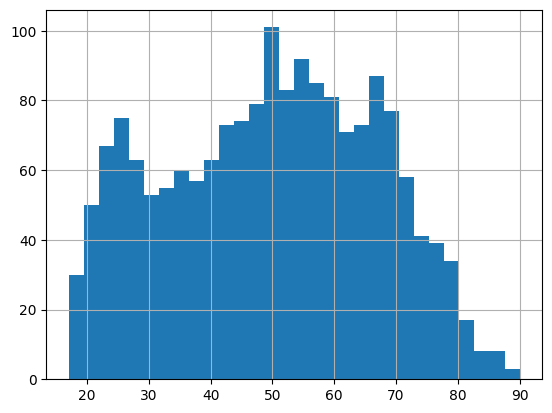

In [32]:
age = df['age']
print('Age: ' + describe(age))
print(f'Mean age = {age.mean()}')
age.hist(bins=30)

In [33]:
center = df['center']
center.value_counts() / N[0]

GE    0.397837
LS    0.375071
BE    0.227092
Name: center, dtype: float64

## 3.3) Collection durations

### 3.3.1) 24-hour collection durations

In [34]:
(np.abs(df.u24_min - (df.ud_min + df.un_min))).max()

6.103515625e-05

In [35]:
duration = df_no_min_duration['u24_hours']
print(f'Median "24 hours" duration (all): ' + describe(duration))

Median "24 hours" duration (all): 24.0. Range: 12.83-42.03. IQR: 1.39


In [36]:
duration = df.u24_hours
print('Median "24 hours" duration: ' + describe(duration))
print(f'{len(df[(duration < 23)])} lower than 23 hours, {len(df[(duration > 25)])} higher than 25 hours.')
print(f'{len(df[(duration < 22)])} lower than 22 hours, {len(df[(duration > 26)])} higher than 26 hours.')

Median "24 hours" duration: 24.0. Range: 21.0-27.0. IQR: 1.24
291 lower than 23 hours, 259 higher than 25 hours.
110 lower than 22 hours, 46 higher than 26 hours.


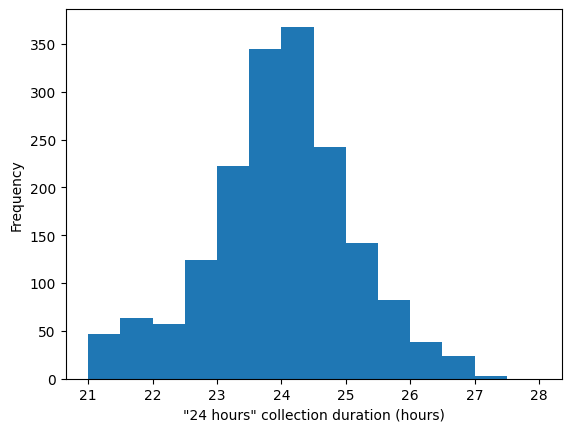

In [37]:
fig, ax = plt.subplots()

max_duration = int(np.max(df['u24_hours'])) + 1
min_duration = int(np.min(df['u24_hours']))
bins = np.linspace(min_duration, max_duration, num=int((max_duration - min_duration) / 0.5) + 1)
ax.hist(df['u24_hours'], bins=bins)
ax.set_xlabel('"24 hours" collection duration (hours)')
ax.set_ylabel('Frequency')
fig.savefig('../Figures/eda/collection_duration.png')

Pearson R: correlation 0.019673229466506424, p-value 0.4098671407551579
Spearman R: correlation 0.005417449339596149, p-value 0.8204851512823567


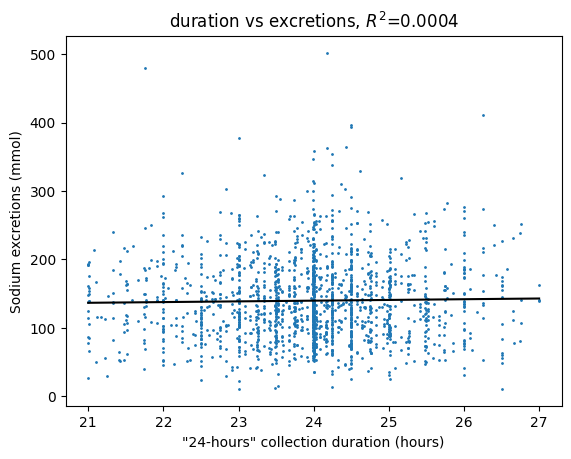

In [38]:
fig, ax = plt.subplots()
ax.scatter(df.u24_hours, df.una_u24_mmol, s=1)
LR = LinearRegression(fit_intercept=True).fit(df.u24_hours.values.reshape(-1, 1), df.una_u24_mmol)
r_squared = LR.score(df.u24_hours.values.reshape(-1, 1), df.una_u24_mmol)
ax.plot(sorted(df.u24_hours), LR.predict(np.array(sorted(df.u24_hours.values.reshape(-1, 1)))), c='k')
ax.set_xlabel('"24-hours" collection duration (hours)')
ax.set_ylabel('Sodium excretions (mmol)')
ax.set_title(f'duration vs excretions, $R^2$={round(r_squared, 4)}')
fig.savefig('../Figures/eda/duration_24sodium.png')
corr, p_value = pearsonr(df.u24_hours, df.una_u24_mmol)
print(f'Pearson R: correlation {corr}, p-value {p_value}')
corr, p_value = spearmanr(df.u24_hours, df.una_u24_mmol)
print(f'Spearman R: correlation {corr}, p-value {p_value}')

Pearson R: correlation -0.09080583068541814, p-value 0.00013816085593872787
Spearman R: correlation -0.0951687115142546, p-value 6.459073833106602e-05


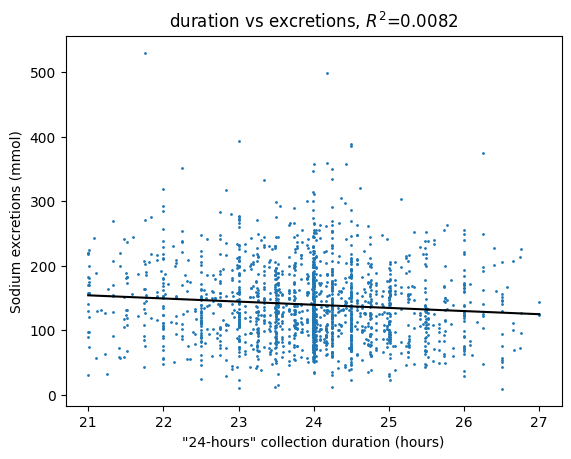

In [39]:
fig, ax = plt.subplots()
ax.scatter(df.u24_hours, df.una_u24corr_mmol, s=1)
LR = LinearRegression(fit_intercept=True).fit(df.u24_hours.values.reshape(-1, 1), df.una_u24corr_mmol)
r_squared = LR.score(df.u24_hours.values.reshape(-1, 1), df.una_u24corr_mmol)
ax.plot(sorted(df.u24_hours), LR.predict(np.array(sorted(df.u24_hours.values.reshape(-1, 1)))), c='k')
ax.set_xlabel('"24-hours" collection duration (hours)')
ax.set_ylabel('Sodium excretions (mmol)')
ax.set_title(f'duration vs excretions, $R^2$={round(r_squared, 4)}')
fig.savefig('../Figures/eda/duration_24sodium_corr.png')
corr, p_value = pearsonr(df.u24_hours, df.una_u24corr_mmol)
print(f'Pearson R: correlation {corr}, p-value {p_value}')
corr, p_value = spearmanr(df.u24_hours, df.una_u24corr_mmol)
print(f'Spearman R: correlation {corr}, p-value {p_value}')

In [40]:
print((df.un_min + df.ud_min - df.u24_min).abs().max())
print((df.una_un_mmol + df.una_ud_mmol - df.una_u24_mmol).abs().max())
print((df.una_un_mmol + df.una_ud_mmol - df.una_u24corr_mmol).abs().max())
print((df.una_un_mmol + df.una_ud_mmol - df.una_u24corr_mmol).abs().mean())

6.103515625e-05
1.52587890625e-05
49.67999999999995
4.856485706397219


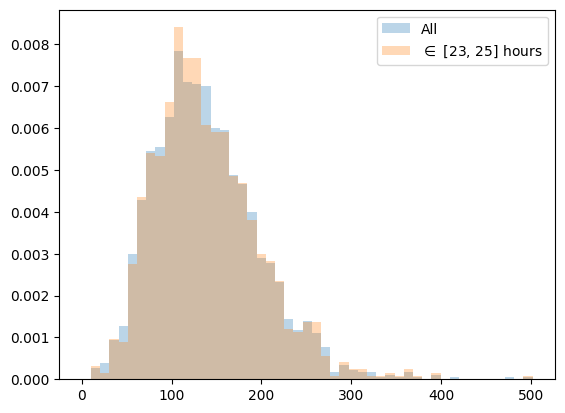

In [41]:
fig, ax = plt.subplots()

all_24 = df['una_u24_mmol']
filtered_24 = df[~((df['u24_hours'] < 23) + (df['u24_hours'] > 25))].una_u24_mmol
max_ = np.max([all_24.max(), filtered_24.max()])
bins = np.linspace(0, max_, num=50)
ax.hist(all_24, bins=bins, label='All', density=True, alpha=0.3)
ax.hist(filtered_24, bins=bins, label='$\in$ [23, 25] hours', density=True, alpha=0.3)
ax.legend();

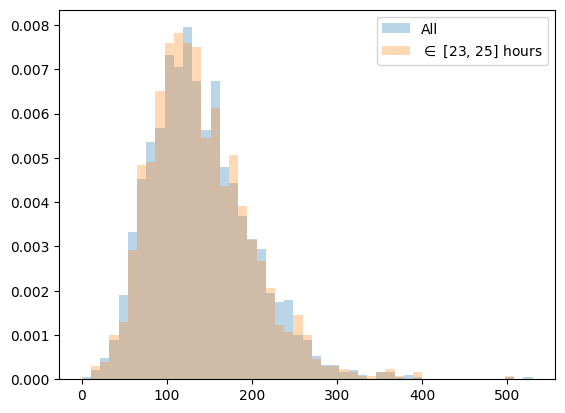

In [42]:
fig, ax = plt.subplots()

all_24 = df['una_u24corr_mmol']
filtered_24 = df[~((df['u24_hours'] < 23) + (df['u24_hours'] > 25))].una_u24_mmol
max_ = np.max([all_24.max(), filtered_24.max()])
bins = np.linspace(0, max_, num=50)
ax.hist(all_24, bins=bins, label='All', density=True, alpha=0.3)
ax.hist(filtered_24, bins=bins, label='$\in$ [23, 25] hours', density=True, alpha=0.3)
ax.legend();

### 3.3.2) Night collection duration

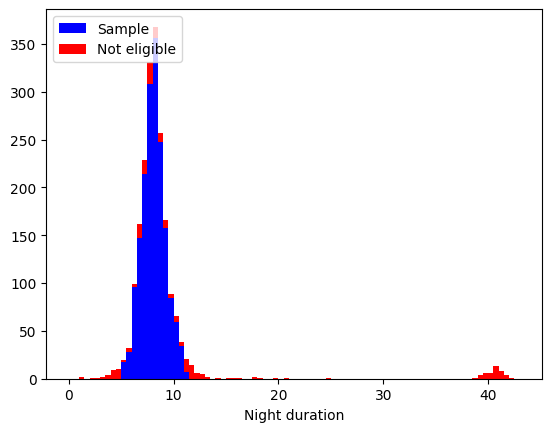

In [43]:
fig, ax = plt.subplots()

max_duration = int(np.max(df_no_min_duration['un_hours'])) + 1
bins = np.linspace(0, max_duration, num=int(max_duration / 0.5) + 1)
ax.hist(df_no_min_duration['un_hours'], bins=bins, color='red', label='Not eligible')
ax.hist(df['un_hours'], bins=bins, color='blue', label='Sample')
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('Night duration')
ax.legend(handles[::-1], labels[::-1], loc='upper left');

In [44]:
duration = df_no_min_duration['un_hours']
print(f'Median night duration (all): ' + describe(duration))

Median night duration (all): 8.01. Range: 1.0-42.0. IQR: 1.74


In [45]:
duration = df['un_hours']
print(f'Median night duration (filtered): ' + describe(duration))

Median night duration (filtered): 8.0. Range: 5.0-11.0. IQR: 1.5


### 3.3.3) Day collection duration

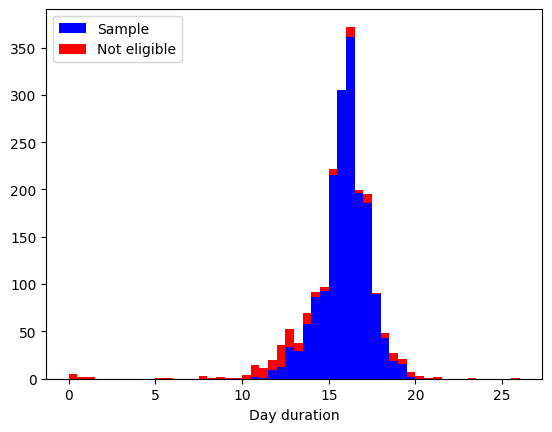

In [46]:
fig, ax = plt.subplots()

max_duration = int(np.max(df_no_min_duration['ud_hours'])) + 1
bins = np.linspace(0, max_duration, num=int(max_duration / 0.5) + 1)
ax.hist(df_no_min_duration['ud_hours'], bins=bins, color='red', label='Not eligible')
ax.hist(df['ud_hours'], bins=bins, color='blue', label='Sample')
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('Day duration')
ax.legend(handles[::-1], labels[::-1], loc='upper left');

## 3.4) Excretions

### 3.4.1) Volume

Median urine volume (night) [mL]: 450.0. Range: 60.0-3820.0. IQR: 370.0
Median urine volume (day) [mL]: 1066.0. Range: 139.0-4200.0. IQR: 782.0
Median urine volume (24 hours) [mL]: 1557.0. Range: 300.0-7350.0. IQR: 974.0
Median urine volume (24 hours corrected) [mL]: 1564.09. Range: 322.6-7274.23. IQR: 966.89

Less than 500mL: 0.005691519635742743. More than 5000mL: 0.001707455890722823.

Less than 500mL (corr.): 0.006829823562891292. More than 5000mL: 0.001707455890722823.


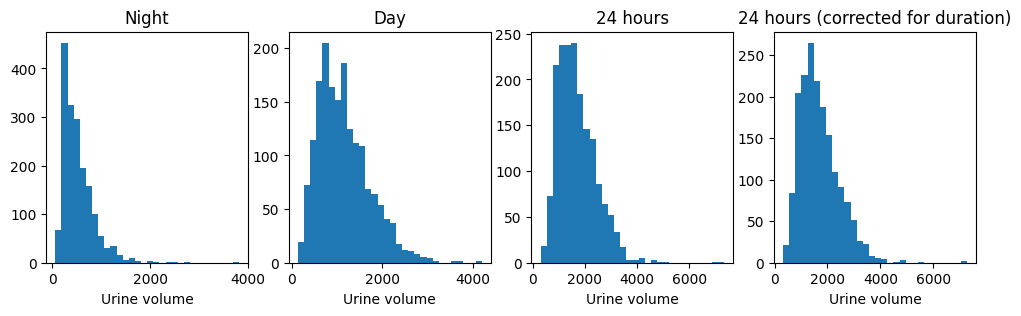

In [47]:
night_volume = df.un_ml
day_volume = df.ud_ml
total_volume = df.u24_ml
total_volume_corr = df.u24corr_ml

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].hist(night_volume, bins=30)
ax[0].set(title='Night', xlabel='Urine volume')
ax[1].hist(day_volume, bins=30)
ax[1].set(title='Day', xlabel='Urine volume')
ax[2].hist(total_volume, bins=30)
ax[2].set(title='24 hours', xlabel='Urine volume')
ax[3].hist(total_volume_corr, bins=30)
ax[3].set(title='24 hours (corrected for duration)', xlabel='Urine volume')

print(f'Median urine volume (night) [mL]: ' + describe(night_volume))
print(f'Median urine volume (day) [mL]: ' + describe(day_volume))
print(f'Median urine volume (24 hours) [mL]: ' + describe(total_volume))
print(f'Median urine volume (24 hours corrected) [mL]: ' + describe(total_volume_corr))
print(f'\nLess than 500mL: {np.mean(total_volume < 500)}. More than 5000mL: {np.mean(total_volume > 5000)}.')
print(f'\nLess than 500mL (corr.): {np.mean(total_volume_corr < 500)}. More than 5000mL: {np.mean(total_volume_corr > 5000)}.')

In [48]:
print(f"Average proportion of volume at night: {(df.un_ml / df.u24corr_ml).mean()}")

Average proportion of volume at night: 0.32042959215900846


### 3.4.2) Sodium

Median urinary sodium (night) [mmol]: 37.5. Range: 2.24-342.0. IQR: 30.8
Median urinary sodium (day) [mmol]: 90.77. Range: 4.4-364.56. IQR: 58.94
Median urinary sodium [mmol]: 132.58. Range: 10.5-502.0. IQR: 76.4
Median urinary sodium (24 hours corrected) [mmol]: 131.88. Range: 9.51-529.92. IQR: 75.96


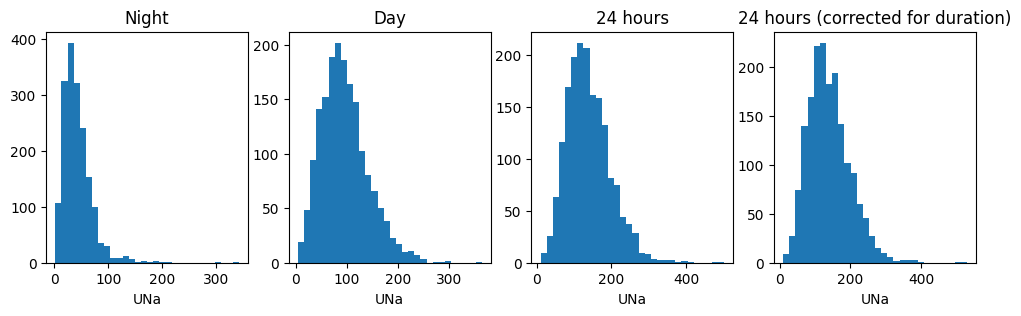

In [49]:
night_na = df.una_un_mmol
day_na = df.una_ud_mmol
total_na = df.una_u24_mmol
total_na_corr = df.una_u24corr_mmol

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].hist(night_na, bins=30)
ax[0].set(title='Night', xlabel='UNa')
ax[1].hist(day_na, bins=30)
ax[1].set(title='Day', xlabel='UNa')
ax[2].hist(total_na, bins=30)
ax[2].set(title='24 hours', xlabel='UNa')
ax[3].hist(total_na_corr, bins=30)
ax[3].set(title='24 hours (corrected for duration)', xlabel='UNa')


print(f'Median urinary sodium (night) [mmol]: ' + describe(night_na))
print(f'Median urinary sodium (day) [mmol]: ' + describe(day_na))
print(f'Median urinary sodium [mmol]: ' + describe(total_na))
print(f'Median urinary sodium (24 hours corrected) [mmol]: ' + describe(total_na_corr))

In [50]:
print(f"Average proportion of sodium excreted at night: {(night_na / total_na_corr).mean()}")

Average proportion of sodium excreted at night: 0.31470991491372713


# 4) Tables

## 4.1) Demographics

In [51]:
cols_num = {
    'age': 'Age [years]', 'bmi': 'BMI [kg/m2]', 'bh1': 'Body height [cm]', 'bwi': 'Body weight [kg]',
    'rate1_5': 'Heart rate (mean of 5) [bpm]', 'sbp1_5': 'Systolic blood pressure (mean of 5) [mmHg]', 'dbp1_5': 'Diastolic blood pressure (mean of 5) [mmHg]',
}
cols_bin = {
    't_now': 'Current smoker [Yes/No]', 't_p_past': 'Past smoker [Yes/No]',
    'hypertension_combined': 'Hypertensive [Yes/No]', 'd_hypt': 'Taking anti-hypertensive drug [Yes/No]',
    'diabetes_combined': 'Diabetic [Yes/No]', 'd_diab': 'Treated for diabetes [Yes/No]',
    'obesity_combined': 'Obese [Yes/No]',
}
descr_stats = get_descriptive_table(df, cols_num, cols_bin)
descr_stats.to_csv('../Figures/eda/descriptive_stats.csv')
descr_stats

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: survival

R[write to console]: 
Attaching package: ‘survey’


R[write to console]: The following object is masked from ‘package:graphics’:

    dotchart




      mean     SE
age 48.421 0.5534
    variance     SE
age    294.6 9.7428
[1] 962
      mean     SE
bmi 25.064 0.1445
    variance    SE
bmi   20.062 1.178
[1] 961
      mean     SE
bh1 170.64 0.2884
    variance     SE
bh1   79.914 3.3011
[1] 961
      mean     SE
bwi 73.157 0.4803
    variance     SE
bwi   221.66 11.498
[1] 961
          mean     SE
rate1_5 66.941 0.3699
        variance     SE
rate1_5   121.91 8.5114
[1] 891
         mean     SE
sbp1_5 118.21 0.5384
       variance     SE
sbp1_5   277.74 15.615
[1] 958
         mean     SE
dbp1_5 75.695 0.3133
       variance     SE
dbp1_5   94.055 4.3654
[1] 958
         mean     SE
t_now 0.23117 0.0136
      variance     SE
t_now  0.17792 0.0073
[1] 956
           mean     SE
t_p_past 0.4819 0.0168
         variance    SE
t_p_past  0.24996 6e-04
[1] 884
                         mean     SE
hypertension_combined 0.32042 0.0151
                      variance     SE
hypertension_combined  0.21798 0.0054
[1] 955
          mean    SE

,Baseline [N=962],Follow-up [N=795],Pooled [N=1757]
Age [years],48.4(0.6) +- 17.2(3.1) [N=962],51.4(0.6) +- 16.8(3.2) [N=795],49.7(0.5) +- 17.0(3.0) [N=1757]
BMI [kg/m2],25.1(0.1) +- 4.5(1.1) [N=961],25.5(0.2) +- 4.6(1.2) [N=792],25.2(0.1) +- 4.5(1.1) [N=1753]
Body height [cm],170.6(0.3) +- 8.9(1.8) [N=961],170.4(0.3) +- 9.1(2.2) [N=792],170.5(0.3) +- 9.0(1.9) [N=1753]
Body weight [kg],73.2(0.5) +- 14.9(3.4) [N=961],74.0(0.5) +- 15.2(3.7) [N=793],73.6(0.5) +- 15.0(3.4) [N=1754]
Heart rate (mean of 5) [bpm],66.9(0.4) +- 11.0(2.9) [N=891],65.8(0.4) +- 10.4(2.8) [N=712],66.4(0.3) +- 10.8(2.5) [N=1603]
Systolic blood pressure (mean of 5) [mmHg],118.2(0.5) +- 16.7(4.0) [N=958],118.0(0.6) +- 15.5(3.8) [N=793],118.1(0.5) +- 16.1(3.5) [N=1751]
Diastolic blood pressure (mean of 5) [mmHg],75.7(0.3) +- 9.7(2.1) [N=958],74.2(0.3) +- 9.1(2.2) [N=793],75.0(0.3) +- 9.5(1.9) [N=1751]
Current smoker [Yes/No],23.1% [N=956],23.6% [N=791],23.4% [N=1747]
Past smoker [Yes/No],48.2% [N=884],48.3% [N=729],48.2% [N=1613]
Hypertensive [Yes/No],32.0% [N=955],28.2% [N=792],30.3% [N=1747]


## 4.2) Urinary measurements

In [52]:
for time in ('u24', 'ud', 'un'):
    df[f'ucrt_{time}_mmol'] = df[f'ucrt_{time}_umol'] / 1000
df['ucrt_u24corr_mmol'] = df['ucrt_u24corr_umol'] / 1000

In [53]:
cols = {
    '{time}_min': 'Urine collection duration [HH:MM]', '{time}_ml': 'Urine collection volume [mL]',
    'una_{time}_mmol': 'Urinary sodium [mmol]', 'uk_{time}_mmol': 'Urinary potassium [mmol]', 'ucrt_{time}_mmol': 'Urinary creatinine [mmol]',
}
ts = []
for pref, lab in [
    ('u24', '24-hour'), ('ud', 'Day-time'), ('un', 'Night-time'), ('u24corr', '24-hour (corr)')
]:
    cols_num = dict(zip([c.format(time=pref) for c in cols], cols.values()))
    t = get_descriptive_table(df, cols_num, {}, show_count=False)
    t['Time'] = lab
    ts.append(t.reset_index().rename(columns={'index': '', 'Time': ' '}).set_index(['', ' ']))
urine_stats = pd.concat(ts).sort_index()
urine_stats.to_csv('../Figures/eda/urine_stats_corr.csv')
urine_stats

          mean     SE
u24_min 1436.9 2.1465
        variance     SE
u24_min   4432.2 210.56
[1] 962
         mean     SE
u24_ml 1717.8 23.965
       variance    SE
u24_ml   552481 39855
[1] 962
               mean     SE
una_u24_mmol 142.51 1.9678
             variance     SE
una_u24_mmol   3725.2 243.96
[1] 962
            mean     SE
uk_u24_mmol 64.3 0.7346
            variance     SE
uk_u24_mmol   519.16 31.755
[1] 962
                mean     SE
ucrt_u24_mmol 12.832 0.1329
              variance     SE
ucrt_u24_mmol   16.986 1.2995
[1] 962
          mean     SE
u24_min 1434.6 2.3792
        variance    SE
u24_min   4500.1 246.7
[1] 795
         mean     SE
u24_ml 1645.3 25.162
       variance    SE
u24_ml   503334 48450
[1] 795
               mean     SE
una_u24_mmol 135.95 2.0163
             variance     SE
una_u24_mmol   3232.2 227.48
[1] 795
              mean     SE
uk_u24_mmol 63.705 0.7445
            variance     SE
uk_u24_mmol   440.64 27.129
[1] 795
               mean   

Baseline [N=962]  \
                                                                                 
Urinary creatinine [mmol]         24-hour                12.8(0.1) +- 4.1(1.1)   
                                  24-hour (corr)         12.9(0.1) +- 4.1(1.1)   
                                  Day-time                8.3(0.1) +- 2.9(0.7)   
                                  Night-time              4.5(0.1) +- 1.9(0.7)   
Urinary potassium [mmol]          24-hour               64.3(0.7) +- 22.8(5.6)   
                                  24-hour (corr)        64.5(0.7) +- 22.8(5.6)   
                                  Day-time              49.0(0.6) +- 19.3(4.3)   
                                  Night-time             15.3(0.3) +- 9.3(4.0)   
Urinary sodium [mmol]             24-hour             142.5(2.0) +- 61.0(15.6)   
                                  24-hour (corr)      142.9(2.0) +- 60.9(15.4)   
                                  Day-time             98.6(1.5) +- 47.5(12.0)   
                                  Night-time            43.9(0.9) +- 27.7(9.6)   
Urine collection duration [HH:MM] 24-hour         23:57(00:02) +- 01:07(00:14)   
                                  24-hour (corr)  24:00(00:00) +- 00:00(00:00)   
                                  Day-time        15:50(00:03) +- 01:21(00:19)   
                                  Night-time      08:07(00:02) +- 01:06(00:14)   
Urine collection volume [mL]      24-hour         1717.8(24.0) +- 743.3(199.6)   
                                  24-hour (corr)  1725.4(24.4) +- 755.6(207.3)   
                                  Day-time        1189.0(19.0) +- 589.9(143.6)   
                                  Night-time        528.9(10.0) +- 309.5(94.3)   

                                                             Follow-up [N=795]  \
                                                                                 
Urinary creatinine [mmol]         24-hour                12.3(0.1) +- 4.2(1.3)   
                                  24-hour (corr)         12.4(0.2) +- 4.3(1.4)   
                                  Day-time                7.8(0.1) +- 2.9(0.7)   
                                  Night-time              4.5(0.1) +- 2.5(1.2)   
Urinary potassium [mmol]          24-hour               63.7(0.7) +- 21.0(5.2)   
                                  24-hour (corr)        64.0(0.8) +- 21.2(5.3)   
                                  Day-time              48.3(0.7) +- 18.5(4.5)   
                                  Night-time             15.4(0.3) +- 9.7(4.0)   
Urinary sodium [mmol]             24-hour             136.0(2.0) +- 56.9(15.1)   
                                  24-hour (corr)      136.9(2.1) +- 58.2(16.1)   
                                  Day-time             93.5(1.6) +- 44.1(10.0)   
                                  Night-time           42.5(1.0) +- 27.7(11.3)   
Urine collection duration [HH:MM] 24-hour         23:55(00:02) +- 01:07(00:16)   
                                  24-hour (corr)  24:00(00:00) +- 00:00(00:00)   
                                  Day-time        15:59(00:03) +- 01:17(00:18)   
                                  Night-time      07:55(00:02) +- 01:08(00:15)   
Urine collection volume [mL]      24-hour         1645.3(25.2) +- 709.5(220.1)   
                                  24-hour (corr)  1656.7(25.7) +- 723.7(220.6)   
                                  Day-time        1120.2(19.6) +- 552.0(142.6)   
                                  Night-time       525.1(11.8) +- 331.8(126.0)   

                                                               Pooled [N=1757]  
                                                                                
Urinary creatinine [mmol]         24-hour                12.6(0.1) +- 4.2(1.1)  
                                  24-hour (corr)         12.6(0.1) +- 4.2(1.1)  
                                  Day-time                8.1(0.1) +- 2.9(0.6)  
                                  Night-time   

In [54]:
df.ucrt_un_mmol.mean(), df.ucrt_u24_mmol.mean(), df.ucrt_u24corr_mmol.mean()

(4.508835484825765, 12.600274769637966, 12.649182855202861)

In [55]:
df.ucrt_un_mmol.mean() / df.ucrt_u24_mmol.mean(), df.ucrt_un_mmol.mean() / df.ucrt_u24corr_mmol.mean()

(0.3578362827206278, 0.35645270816613983)